In [1]:
import sys
sys.path.append('../..')

import eeg_decoder
import numpy as np
from collections import OrderedDict
%load_ext autoreload
%autoreload 2

In [2]:
experiment_name = 'e'
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1500])

In [3]:
time_window = 25 
time_step = 25
trial_bin_size = 15 
n_splits = 1000
group_dict = OrderedDict([('1',[11,21]),('2',[12,22])])
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)
clfr = eeg_decoder.Classification(wrangl,exp.nsub,num_labels=2)

In [4]:
for isub in range(exp.nsub):

    print(isub)
    xdata,ydata = exp.load_eeg(isub)

    xdata_color, ydata_color = wrangl.select_labels(xdata,ydata,labels=[11,12])
    xdata_motion, ydata_motion = wrangl.select_labels(xdata,ydata,labels=[21,22])
    xdata_color, ydata_color = wrangl.group_labels(xdata_color, ydata_color)
    xdata_motion, ydata_motion = wrangl.group_labels(xdata_motion, ydata_motion)

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_custom_split(xdata_color,xdata_motion,ydata_color,ydata_motion):

        X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)
        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

interp = eeg_decoder.Interpreter(clfr, subtitle='color_to_motion') 
interp.save_results(timestamp=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [11]:
interp = eeg_decoder.Interpreter()
interp.load_results('color_to_motion')

Significant timepoints: [ 136  160  184  208  232  256  280  304  328  352  376  400  424  448
  472  496  520  544  568  592  616  640  664  688  712  736  760  784
  808  856  880  952  976 1000 1024 1048 1072 1096 1120 1168 1192 1264
 1360 1456]
Saving output\figures\acccolor_to_motion.pdf
Saving output\figures\acccolor_to_motion.png


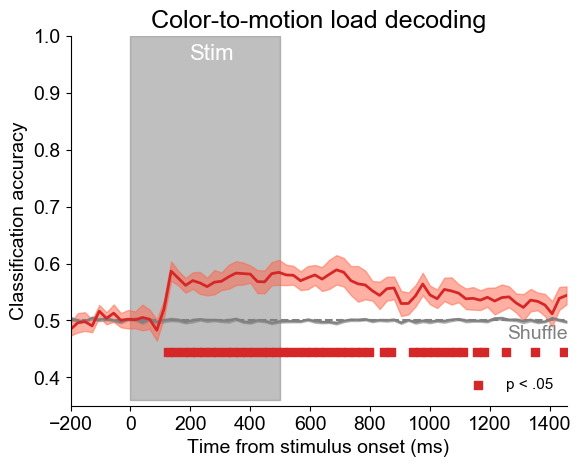

Mean delay accuracy: 0.55088
Mean delay S.D.: 0.019188923743775853


In [12]:
import matplotlib.pyplot as plt
interp.chance = .5
interp.labels = [0,1]
interp.plot_acc(significance_testing=True,savefig=True,
                ylim=[0.35,1],chance_text_xy=[.88,.22],
                stim_text_xy=[.24,.98],stim_time=[0,500],
                title='Color-to-motion load decoding',subtitle='color_to_motion')
plt.show()

In [5]:
for isub in range(exp.nsub):

    print(isub)
    xdata,ydata = exp.load_eeg(isub)

    xdata_color, ydata_color = wrangl.select_labels(xdata,ydata,labels=[11,12])
    xdata_motion, ydata_motion = wrangl.select_labels(xdata,ydata,labels=[21,22])
    xdata_color, ydata_color = wrangl.group_labels(xdata_color, ydata_color)
    xdata_motion, ydata_motion = wrangl.group_labels(xdata_motion, ydata_motion)

    for X_train_all, X_test_all, y_train, y_test in wrangl.bin_and_custom_split(xdata_motion,xdata_color,ydata_motion,ydata_color):

        X_train_all, X_test_all, y_train, y_test = wrangl.balance_data(X_train_all, X_test_all, y_train, y_test)
        y_test_shuffle = np.random.permutation(y_test)

        for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
            clfr.decode(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

interp = eeg_decoder.Interpreter(clfr, subtitle='motion_to_color') 
interp.save_results(timestamp=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [13]:
interp = eeg_decoder.Interpreter()
interp.load_results('motion_to_color')

Significant timepoints: [ 136  160  184  208  232  256  280  304  328  352  376  400  424  448
  472  496  520  544  568  592  616  640  664  688  712  736  784  808
  880  976 1000 1024 1048 1192 1264 1456]
Saving output\figures\accmotion_to_color.pdf
Saving output\figures\accmotion_to_color.png


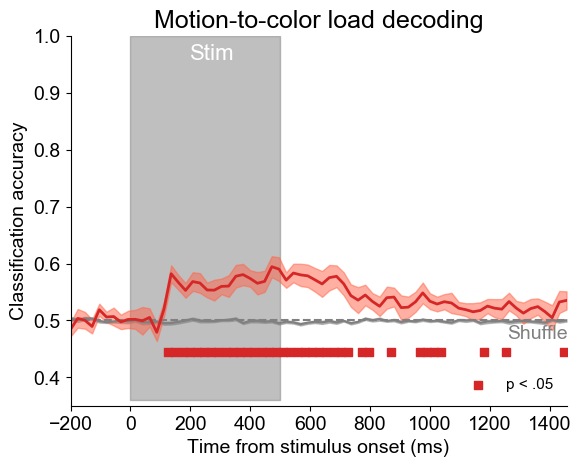

Mean delay accuracy: 0.5380708333333334
Mean delay S.D.: 0.021488152016479554


In [15]:
import matplotlib.pyplot as plt
interp.chance = .5
interp.labels = [0,1]
interp.plot_acc(significance_testing=True,savefig=True,
                ylim=[0.35,1],chance_text_xy=[.88,.22],
                stim_text_xy=[.24,.98],stim_time=[0,500],
                title='Motion-to-color load decoding',subtitle='motion_to_color')
plt.show()

# Within-Feature compared to Across-Feature

# Color

In [16]:
interp_color = eeg_decoder.Interpreter()
interp_color.combine_interps(['color','motion_to_color'], overwrite_current_interp=True)

Within-color mean delay accuracy: 0.6119697222222222
Within-color mean delay S.D.: 0.029230846555564165
Motion-to-color mean delay accuracy: 0.5380708333333334
Motion-to-color mean delay S.D.: 0.021488152016479554
mean delay accuracy: 0.5380708333333334
mean delay S.D.: 0.021488152016479554
Saving output\figures\accwithin_color_and_motion_to_color.pdf
Saving output\figures\accwithin_color_and_motion_to_color.png


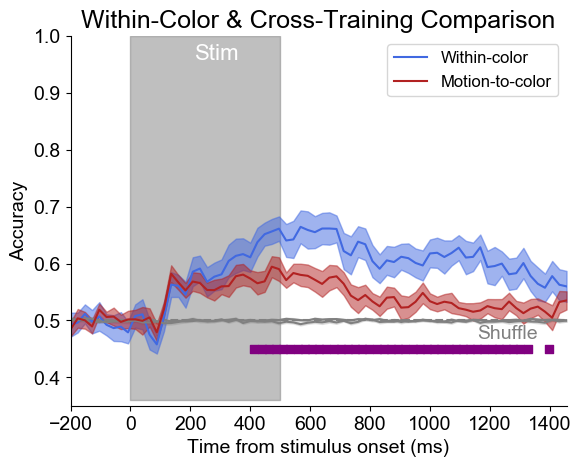

In [18]:
interp_color.plot_acc_compare_subset(
    subset_list=['Within-color','Motion-to-color'],
    ylim=[.35,1], 
    chance=.5, 
    chance_text_xy=[.82,.22],
    stim_time=[0,500],
    significance_testing=True,
    subtitle='within_color_and_motion_to_color',
    title='Within-Color & Cross-Training Comparison',
    savefig=True)

# Motion 

In [19]:
interp_motion = eeg_decoder.Interpreter()
interp_motion.combine_interps(['motion','color_to_motion'], overwrite_current_interp=True)

Within-motion mean delay accuracy: 0.6628204166666667
Within-motion mean delay S.D.: 0.01966906032935913
Color-to-motion mean delay accuracy: 0.55088
Color-to-motion mean delay S.D.: 0.019188923743775853
mean delay accuracy: 0.55088
mean delay S.D.: 0.019188923743775853
Saving output\figures\accwithin_motion_and_color_to_motion.pdf
Saving output\figures\accwithin_motion_and_color_to_motion.png


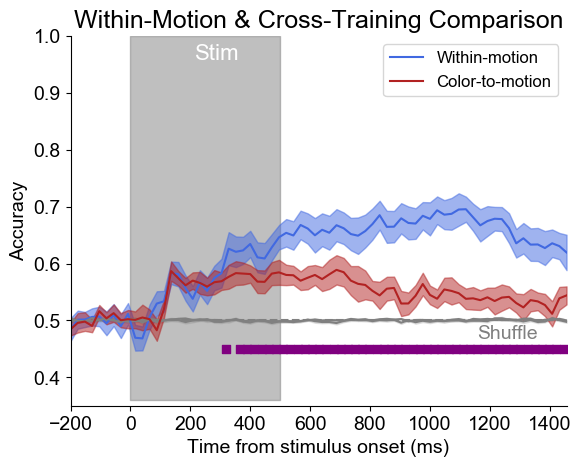

In [20]:
interp_motion.plot_acc_compare_subset(
    subset_list=['Within-motion','Color-to-motion'],
    ylim=[.35,1], 
    chance=.5, 
    chance_text_xy=[.82,.22],
    stim_time=[0,500],
    significance_testing=True,
    subtitle='within_motion_and_color_to_motion',
    title='Within-Motion & Cross-Training Comparison',
    savefig=True)